# QR iteration

The QR iteration and Hessenberg transformation will be investigated on a simple matrix.

.2....95.-38..18..5  
.1....47.-19....8..1  
.2..151.-69..28..4  
-1..218.-88..34..6  
.0.-208..84.-34.-5

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math as m

### Creating the matrix

In [2]:
data = [2, 95, -38, 18, 5, 1, 47, -19, 8, 1, 2, 151, -69, 28, 4, -1, 218, -88, 34, 6, 0, -208, 84, -34, -5]

In [3]:
task = np.array(data).reshape((5, 5))
print (task)

[[   2   95  -38   18    5]
 [   1   47  -19    8    1]
 [   2  151  -69   28    4]
 [  -1  218  -88   34    6]
 [   0 -208   84  -34   -5]]


## QR Iteration - Implementation

The $S_{ij}$ matrix which can make an element zero is sparse. Therefore it is represented by a special structure:

In [4]:
class S:
    
    def __init__(self, i, j, tan = 0):
        self.i = i
        self.j = j
        self.sin = self.__to_sin(tan)
        self.cos = self.__to_cos(tan)
        
    def __to_sin(self, tan):
        return tan / m.sqrt(1.0 + tan * tan)
    
    def __to_cos(self, tan):
        return 1.0 / m.sqrt(1.0 + tan * tan)
    
    def infinity_tan(self):
        self.sin = 1.0
        self.cos = 0.0

The $S_{ij}$ means the $i^{th}$ element in the $j^{th}$ column will be zero in matrix **A**. This multiplication should exhaust the fact that $S_{ij}$ is sparse.

In [5]:
def sij_dot_A(s_ij, A): # A should be a numpy matrix
    for idx in range(0, A.shape[1]):
        temp = A[s_ij.j, idx] * s_ij.cos + A[s_ij.i, idx] * s_ij.sin
        A[s_ij.i, idx] = A[s_ij.i, idx] * s_ij.cos - A[s_ij.j, idx] * s_ij.sin
        A[s_ij.j, idx] = temp 

After eliminating all the zeros under the diagonal the transpose of S-s are applied from the right to get the new A.

In [6]:
def A_dot_transpose_sij(A, s_ij):
    for idx in range(0, A.shape[0]):
        temp = A[idx, s_ij.j] * s_ij.cos + A[idx, s_ij.i] * s_ij.sin
        A[idx, s_ij.i] = A[idx, s_ij.i] * s_ij.cos - A[idx, s_ij.j] * s_ij.sin
        A[idx, s_ij.j] = temp

The actual S for the current state of the A at i, j:

In [7]:
def next_s(A, i, j, tolerance=1e-10):
    if abs(A[j, j]) < tolerance:
        s = S(i, j)
        s.infinity_tan()
        return s
    else:
        tan = A[i, j] / A[j, j]
        return S(i, j, tan)

The eigenvalues are given as the diagonal elements in the A after sufficient number of QR iteration. A function for accessing the diagonal elements:

In [8]:
def diagonals(A):
    eis = []
    for idx in range(0, A.shape[0]):
        eis.append(A[idx, idx])
        
    return eis

Then one step in the QR iteration ($A(k+1) = Q^T \cdot A(k) \cdot Q$) can be implemented in the following way:

In [9]:
def qr_one_step(A):
    s_list = []
    for j in range(0, A.shape[1]): # multiplications from left, erasing zeros in the j. column 
        for i in range(A.shape[0] - 1, j, -1):
            s_temp = next_s(A, i, j)
            sij_dot_A(s_temp, A)
            s_list.append(s_temp)
    
    for s in s_list: # multiplying from right, the order is good due to append
        A_dot_transpose_sij(A, s)

Then the QR iteration is given as follows:

In [10]:
def qr(A, iter_num = 5, callback = None, shift = False): # shift: True shifting is applied
    
    # helper for calculating the error
    def sum_sq():
        loss = 0.0
        for x in diagonals(A):
            loss += x * x
        return loss
    
    ei_sum_0 = sum_sq()
    
    for it in range(iter_num):
        
        if shift:
            DeltaA = A[-1, -1] * np.identity(A.shape[0])
            A -= DeltaA
            qr_one_step(A)
            A += DeltaA
        else:
            qr_one_step(A)
        
        # error calculation and administration
        ei_sum_1 = sum_sq()
        error = ei_sum_1 - ei_sum_0
        
        if not (callback is None):
            callback(error)
            
        ei_sum_0 = ei_sum_1

#### Test for the current functions

In [11]:
#test = [6.0, 2.0, 1.0, 2.0, 4.0, 2.0, 1.0, 2.0, 1.0]
test = [1.0, -1.0, 0.0, 0.0, -1.0, 1.0, -1.0, 0.0, 0.0, -1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 3.0] # Example from the book
mtx = np.array(test).reshape((4, 4))
print("The matrix: \n", mtx)

print("\n --- Built-in ---")
print(np.linalg.eig(mtx)[0]) # uses _geev LAPACK routines (see references)

print("\n --- QR ITERATION ---")
qr(mtx, 20)
print(mtx)
print(diagonals(mtx))

The matrix: 
 [[ 1. -1.  0.  0.]
 [-1.  1. -1.  0.]
 [ 0. -1.  2.  0.]
 [ 0.  0.  0.  3.]]

 --- Built-in ---
[-0.2469796   1.44504187  2.80193774  3.        ]

 --- QR ITERATION ---
[[  2.80193774e+00   5.40237406e-06  -1.58234952e-16   0.00000000e+00]
 [  5.40237406e-06   1.44504187e+00  -1.44730606e-15   0.00000000e+00]
 [ -2.97124760e-35  -1.37961794e-15  -2.46979604e-01   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   3.00000000e+00]]
[2.8019377357833295, 1.445041867934139, -0.24697960371746711, 3.0]


## Transformation to Hessenberg matrix - Imlementation

The shape of the Hessenberg matrix remains invariant for the QR transformation. Therefore after a QR transformation the resulting matrix is also in Hessenberg form.

In [12]:
def transform_Hessenberg(A):
    # init F
    F = np.zeros(A.shape) 
    for idx in range(1, A.shape[0]):
        F[idx, idx - 1] = 1.0
    
    # init Z
    Z = np.zeros(A.shape)
    Z[0, 0] = 1.0
    
    # recursive formula: Fik = (A * Zk)_i - sum_j=1^i-1 {Fjk * Zij} / Z_ii
    for k in range(1, A.shape[1] + 1):
        Azk = np.matmul(A, Z[:, k - 1])
        
        for i in range(0, k):
            temp = 0.0
            for j in range(0, i):
                temp += F[j, k - 1] * Z[i, j]
            F[i, k - 1] = (Azk[i] - temp) / Z[i, i]
        
        if k < A.shape[1]: # to get the last row of F, but here Z[:, k] would be out of range
            Z[:, k] = Azk[:]
            for t in range(0, k):
                Z[:, k] -= F[t, k - 1] * Z[:, t]
    
    return F, Z

#### Test for Hessenberg transformation

In [13]:
test = [1, 1, -1, 1, 1, 2, -2, 1, 2, 1, -1, 2, 3, 2, -1, 2] # example from the book
mtx = np.array(test).reshape((4, 4))
print("The matrix: \n", mtx)

F, Z = transform_Hessenberg(mtx)
print("F: \n", F)
print("Z: \n", Z)

The matrix: 
 [[ 1  1 -1  1]
 [ 1  2 -2  1]
 [ 2  1 -1  2]
 [ 3  2 -1  2]]
F: 
 [[ 1.  2.  0.  3.]
 [ 1.  1. -3.  3.]
 [ 0.  1.  3.  0.]
 [ 0.  0.  1. -1.]]
Z: 
 [[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  2.  3.  0.]
 [ 0.  3.  3.  3.]]


## Experiments with the given matrix

The following subtasks will be investigated:
1. QR iteration without Hessenberg (convergence speed, eigenvalues)
2. QR iteration with Hesenberg (convergence speed, eigenvalues)
3. Effect of shifting
4. Applying Gauss-noise with different variance but zero mean. (Difference in lambda)

In [14]:
# Functions which will be used in the following tasks

history = { "it": [], "err": []}
def monitor_error(error):
    history["err"].append(error)
    history["it"].append(len(history["it"]) + 1)
    
def show_graph(title):
    plt.plot(history["it"], history["err"])

    plt.xlabel('iteration')
    plt.ylabel('error')
    plt.title(title)
    plt.show()

def clear_history():
    history["it"].clear()
    history["err"].clear()

### QR without Hessenberg

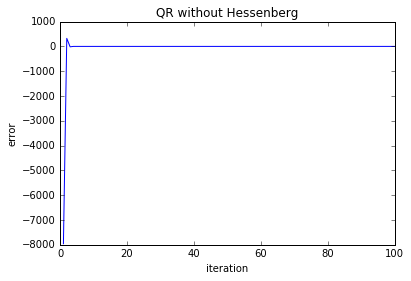

QR solution:  [21, -8, 0, 0, 0]
Reference solution:  [ 25.57771123+0.j        -12.31982385+0.j         -3.21680685+1.4877582j
  -3.21680685-1.4877582j   2.17572632+0.j       ]


In [15]:
qr_mtx = np.copy(task)

qr(qr_mtx, 100, callback = monitor_error)

show_graph("QR without Hessenberg")
clear_history()

print("QR solution: ", diagonals(qr_mtx))
print("Reference solution: ", np.linalg.eig(task)[0])

### QR with Hessenberg

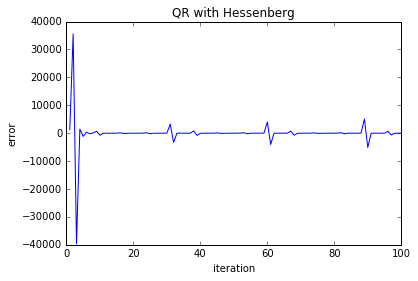

QR solution:  [25.577711226533314, -12.31982384870429, -3.0944995618683433, -3.3391141383989722, 2.1757263224383112]
Reference solution:  [ 25.57771123+0.j        -12.31982385+0.j         -3.21680685+1.4877582j
  -3.21680685-1.4877582j   2.17572632+0.j       ]


In [16]:
qr_mtx = np.copy(task)

qr_f, _ = transform_Hessenberg(qr_mtx)
qr(qr_f, 100, callback = monitor_error)

show_graph("QR with Hessenberg")
clear_history()

print("QR solution: ", diagonals(qr_f))
print("Reference solution: ", np.linalg.eig(qr_mtx)[0])

### Effect of shifting

The shifting did not speed up the convergence here. May be the curve is not so noisy then above.

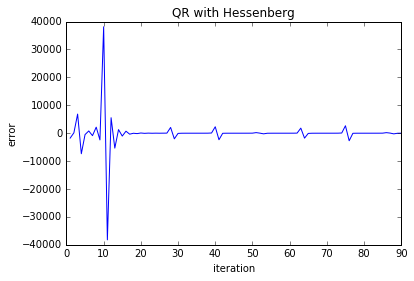

QR solution:  [25.577711226533555, -12.319823848704678, -4.3116642159981016, -2.1219494842690216, 2.1757263224381762]
Reference solution:  [ 25.57771123+0.j        -12.31982385+0.j         -3.21680685+1.4877582j
  -3.21680685-1.4877582j   2.17572632+0.j       ]


In [17]:
qr_mtx = np.copy(task)

qr_f, _ = transform_Hessenberg(qr_mtx)
qr(qr_f, 90, callback = monitor_error, shift = True)

show_graph("QR with Hessenberg")
clear_history()

print("QR solution: ", diagonals(qr_f))
print("Reference solution: ", np.linalg.eig(qr_mtx)[0])

### Applying noise

In this part only the QR with Hessenberg transformation is used due to the observation that the vanilla QR was not able to converge to the right eigenvalues. 

In [18]:
np.random.seed(14)
def noise(sigma): # standard normal distribution in the background
    return np.random.randn(5, 5)/sigma

# examples
qr_mtx = np.copy(task)
qr_noise1 = qr_mtx + noise(1) # medium noise
qr_noise2 = qr_mtx + noise(0.1) # huge noise
qr_noise3 = qr_mtx + noise(10) # small noise

print("Original: \n", qr_mtx)
print("Noise 1: \n", qr_noise1)
print("Noise 2: \n", qr_noise2)
print("Noise 3: \n", qr_noise3)

Original: 
 [[   2   95  -38   18    5]
 [   1   47  -19    8    1]
 [   2  151  -69   28    4]
 [  -1  218  -88   34    6]
 [   0 -208   84  -34   -5]]
Noise 1: 
 [[   3.55133911   95.07918602  -37.82602347   17.92766343    2.9956706 ]
 [   1.14467781   45.49883138  -18.78889055    7.44179494    2.08452906]
 [   1.81371088  151.01466137  -70.07556947   28.64225207    3.81966329]
 [  -0.37969975  218.81097433  -87.22206413   33.76251032    4.10808765]
 [  -1.17212179 -207.16379303   85.0092734   -32.70690064   -5.54933117]]
Noise 2: 
 [[  -7.81712865  104.14672758  -29.26929622   18.22111142    4.95856416]
 [ -12.49126151   44.91782154   -5.73459715   -1.1626058    -3.70013146]
 [   0.50557479  147.74739883  -87.05723456   22.99629811   -1.64780646]
 [  -4.14428573  214.03322763  -87.94066888   24.02861754   22.91097584]
 [  -3.16440871 -193.34865579   98.63601335  -32.71088671  -16.78242861]]
Noise 3: 
 [[  1.78334908e+00   9.48478187e+01  -3.80292888e+01   1.80160488e+01
    4.921714

##### First, the medium noise is applied. The result shows that the real eigenvalues are found with a good accuracy. 

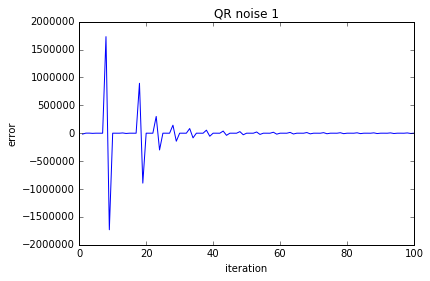

QR solution:  [15.622934975637049, -13.417960895857021, -5.0524514409202119, 9.8901908572182524, 0.14506667993733546]
Reference solution:  [ 15.62293436+0.j         -13.41796028+0.j           2.41886971+7.40070169j
   2.41886971-7.40070169j   0.14506668+0.j        ]


In [19]:
qr_f, _ = transform_Hessenberg(qr_noise1)
qr(qr_f, 100, callback = monitor_error)

show_graph("QR noise 1")
clear_history()

print("QR solution: ", diagonals(qr_f))
print("Reference solution: ", np.linalg.eig(qr_noise1)[0])

##### Second, the huge noise is applied. Here the peaks are more frequent in the convergence graph.

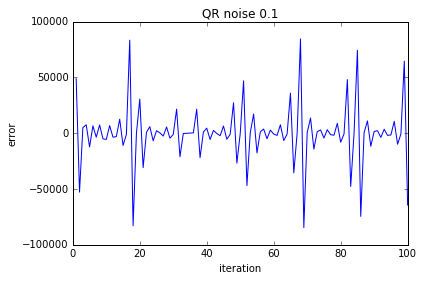

QR solution:  [-35.304121145181327, 23.84287851857826, -2.4514772214322775, -21.911302867993491, -6.8863300318532099]
Reference solution:  [ 10.69580584+21.56169087j  10.69580584-21.56169087j -35.30412115 +0.j
  -6.88633003 +0.j         -21.91151326 +0.j        ]


In [20]:
qr_f, _ = transform_Hessenberg(qr_noise2)
qr(qr_f, 100, callback = monitor_error)

show_graph("QR noise 0.1")
clear_history()

print("QR solution: ", diagonals(qr_f))
print("Reference solution: ", np.linalg.eig(qr_noise2)[0])

##### Third, small noise is applied. Results are similar like in the reference case.

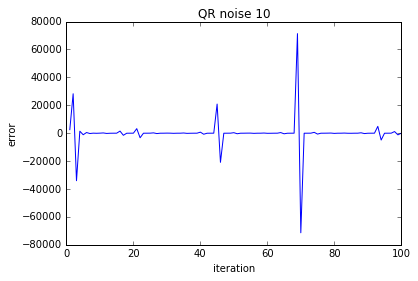

QR solution:  [25.554995078339488, -12.92495568462145, -3.0460445125723323, -2.2977865779190187, 1.8608675131502215]
Reference solution:  [ 25.55499508+0.j         -12.92495568+0.j           1.86086751+0.j
  -2.67191555+2.04483834j  -2.67191555-2.04483834j]


In [21]:
qr_f, _ = transform_Hessenberg(qr_noise3)
qr(qr_f, 100, callback = monitor_error)

show_graph("QR noise 10")
clear_history()

print("QR solution: ", diagonals(qr_f))
print("Reference solution: ", np.linalg.eig(qr_noise3)[0])

## Conclusions

* For this specific example the vanilla QR iteration was not able to find the eigenvalues.
* If the transformation to Hessenberg-form was applied then the real eigenvalues were found with sufficient accuracy within a small number of iteration.
* Shifting has not shown the expected effect. Instead it slightly made slower the convergence. The noise became smaller a bit at the middle part of the curve.
* Huge noise cause fluctuating convergence curves. But results show the same charactereistics as the baseline regarding real and complex eigenvalues.

## Reference

* Rózsa Pál, Lineáris algebra és alkalmazásai, 3. kiadás, 1991
* https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.linalg.eig.html (the refernce calculation of the eigenvalues was based on the numpy library corresponding function)